In [1]:
# BASELINE and Advanced MODEL TRAINING
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load cleaned dataset
df = pd.read_csv("/content/clean_email_dataset.csv")

In [3]:
print(df.isnull().sum())


text     0
label    1
dtype: int64


In [4]:
df = df.dropna()


In [6]:
# Recreate TF-IDF features
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['text'])  # eliminate NaN issues
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [7]:
# Initialize and train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.99      0.97      1133
        spam       0.97      0.83      0.89       293

    accuracy                           0.96      1426
   macro avg       0.96      0.91      0.93      1426
weighted avg       0.96      0.96      0.96      1426



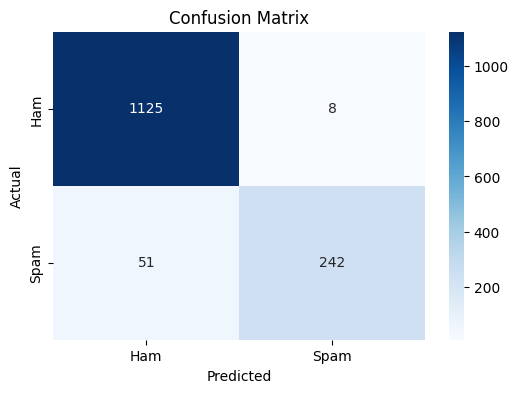

Accuracy: 0.96


In [8]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d",
            cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

In [9]:
# Get top 20 spam/ham indicators
feature_names = tfidf.get_feature_names_out()
ham_coefs = nb_model.feature_log_prob_[0]
spam_coefs = nb_model.feature_log_prob_[1]

top_ham_words = [feature_names[i] for i in ham_coefs.argsort()[-20:][::-1]]
top_spam_words = [feature_names[i] for i in spam_coefs.argsort()[-20:][::-1]]

print("Top Ham Indicators:", top_ham_words)
print("Top Spam Indicators:", top_spam_words)

Top Ham Indicators: ['ect', 'enron', 'hou', 'subject', 'hpl', 'deal', 'xl', 'vince', 'meter', 'please', 'gas', 'thanks', 'com', 'pm', 'cc', 'nom', 'see', 'attach', 'know', 'file']
Top Spam Indicators: ['subject', 'http', 'com', 'get', 'www', 'click', 'price', 'online', 'want', 'email', 'remove', 'free', 'money', 'save', 'new', 'order', 'time', 'offer', 'prescription', 'best']


In [10]:
#EXPERIMENT WITH ADVANCED MODELS

# a) SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Randomized Search
svm_model = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, n_jobs=-1)
svm_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']})

In [11]:
# b) Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]})

In [12]:
# c) LSTM Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Ensure labels are numeric (0 for ham, 1 for spam)
df["label"] = df["label"].map({"ham": 0, "spam": 1})

# Convert text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df["text"])
X_seq = tokenizer.texts_to_sequences(df["text"])
X_pad = pad_sequences(X_seq, maxlen=200)

# Split sequences
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, df["label"], test_size=0.2, random_state=42)

# Convert labels to numpy array (ensures correct dtype)
import numpy as np
y_train_lstm = np.array(y_train_lstm)
y_test_lstm = np.array(y_test_lstm)

# Model architecture
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.8095 - loss: 0.4294
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 372ms/step - accuracy: 0.9867 - loss: 0.0570
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.9960 - loss: 0.0184
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.9982 - loss: 0.0082
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 324ms/step - accuracy: 0.9998 - loss: 0.0034


In [13]:
# 3) MODEL COMPARISON

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Model comparison
models = {
    "Naive Bayes": nb_model,
    "SVM": svm_model.best_estimator_,
    "Random Forest": rf_model.best_estimator_
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label="spam"),
        "Recall": recall_score(y_test, y_pred, pos_label="spam")
    })

results_df = pd.DataFrame(results)
print(results_df)


           Model  Accuracy  Precision    Recall
0    Naive Bayes  0.958626   0.968000  0.825939
1            SVM  0.985273   0.962585  0.965870
2  Random Forest  0.964236   0.961832  0.860068


In [14]:
# HYPERPARAMETER TUNING
# -> Grid Search for SVM

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Randomized Search for SVM
svm_random = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, n_jobs=-1, random_state=42)
svm_random.fit(X_train, y_train)
print("Best SVM Params:", svm_random.best_params_)

Best SVM Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}


In [15]:
# 4) SCALABLE TRAINING PIPELINE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import joblib

# Convert text column to string
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(str)

# Fit TF-IDF vectorizer separately
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(df['text'])

# Train SVM model
svm = SVC(kernel='linear', gamma='scale', C=1, probability=True)
svm.fit(X, df['label'])

# Save vectorizer and model separately
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(svm, "svm_model.pkl")

print("Vectorizer and SVM trained and saved!")

Vectorizer and SVM trained and saved!
